# Clustering
Following [*Python Machine Learning 3rd Edition, Chapter 11*](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch11) and [*Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, Chapter 9*](https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb).

<img src='files/diagrams/unsupervised-clustering.png' style='height: 500px'>

[Image source Machine Learning with Python 3rd Edition](https://github.com/rasbt/python-machine-learning-book-3rd-edition)

- We need clustering when we don't have class labels, making this an unsupervised problem.  
- When we need to discover a latent or hidden structure. We may have a hypothesis on what this structure might be in logical terms, but in reality most of the algorithms are going to be looking at maximizing distance between centroids.  
- Clusters should contain examples that are more similar to each other than in different clusters.  

## When might we need to use clustering?
- Determine documents that are similar to each other.  
- Group songs when we don't have information on their genre.  
- Generation tasks, where should this new sample belong?  
- Customer segmentation for marketing campaigns.  
- Determine outliers in higher dimension datasets.  

## General practices
- Most clustering algorithms use `distance` in some manner. Therefore, it is a best practice to `scale` your data prior to using these algorithms. Since distance will be influenced by absolute magnitudes, it is crucial you don't skip this step (and you shouldn't be skipping it for other modeling tasks either!).  
- To visually inspect the clustering, a standard practice is to use dimensionality reduction (e.g., `principle component analysis`) to remove some of the background noise in the data.  
- Another standard practice is to use dimensionality reduction to compress the feature space to 2 or 3 dimensions in order to visualize the separation in the clusters - though the preceived distance in 2 dimensions may not be reflect of the absolute or relative difference in the full $d$-dimensional space.  
- We'll need a subject matter expert (SME) to review our results and determine the purity of the clusters. If you had some labeled examples you could get a sense of purity using those, but in many cases you'll need some type of feedback loop with reviewers.

## Primary types of Clustering
- Prototype-based (e.g., k-means) clustering. 
- Hierarchical (agglomerative) clustering.  
- Density-based clustering.  
- Graph-based clustering.  

# k-Means Clustering
- Type of `prototype-based` clustering - it needs a prototype or model for each cluster that is usually a centroid (mean/center) or medoid (median).  
- Identifies spherical shapes well.  
- Every example gets assigned a cluster, even if it is a true outlier.  
- Biggest downside is you need to tell the algorithm how many clusters there are...  
- A bad decision for the number of clusters ($k$) and our performance will be poor.  

Demonstrate on the `iris` data:

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_df = iris.data
iris_label = iris.target

iris_df[:5, :]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

#### Squeeze to 2-dimensions for visualizing
We'll use PCA to reduce the dataset to 2-dimensions.  
- Scale the data.    
- Apply PCA to reduce to 2-dimensions.  
- Plot the data

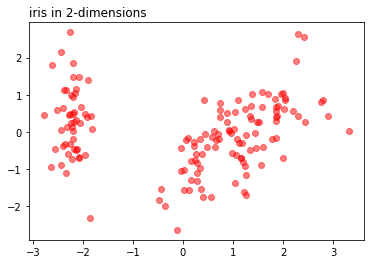

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

iris_p = Pipeline([('scale', StandardScaler()),
                   ('pca', PCA(n_components=2))
                  ])

iris_2d = iris_p.fit_transform(iris_df)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(iris_2d[:,0], iris_2d[:,1], 'ro', alpha=0.5)
plt.title('iris in 2-dimensions', loc='left')
plt.show()

> We know there are 3 classes of `iris` but if we didn't have that info, we would probably assume there are 2 based on this plot.

## Basic Process with k-means
- Pick $k$. 
- Pick $k$ centroids randomly and assign as the initial centers.  
- Assign each example to the nearest cluster, based on `distance`.  
- Move the centroids to the center of the examples that were assigned to it.  
- Repeat until the centroids stop changing, either based on a tolerance or iteration threshold.  

### Distance
Usually this will be `squared Euclidean distance`, where $j$ is the $j$th dimension:

$$
d(x,y)^2 = \sum_{j=1}^{m}(x_j - y_j)^2 = ||x-y||_2^2
$$

### Minimizing within-cluster errors
Going to minimize the within-cluster errors using the `sum of squared errors`, leveraging `Euclidean distance`.

$$
SSE = \sum_{i=1}^{n}{\sum_{j=1}^{k}}w^{(i,j)}||x^{(i)}-\mu^{(j)}||_2^2
$$

$\mu^{j}$ is the $j$th centroid, $i$ is for the $i$-th example, $w^{(i,j)}$ is an indicator for belonging to the cluster:

$$
\begin{equation}
w^{(i,j)}
=
\begin{cases}
1, & \text{if}\ x^{(i)}\in j \\
0, & \text{otherwise}
\end{cases}
\end{equation}
$$

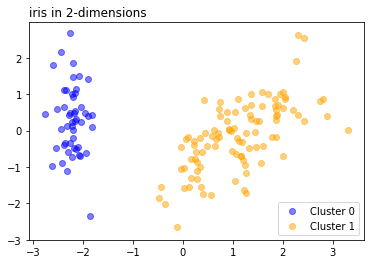

In [3]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 2, init='random')
km = km.fit(iris_2d)
iris_cluster = km.predict(iris_2d)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(iris_2d[iris_cluster == 0, 0], 
            iris_2d[iris_cluster == 0, 1], color='blue',
            alpha=0.5,
            label='Cluster 0'
           )

plt.scatter(iris_2d[iris_cluster == 1, 0], 
            iris_2d[iris_cluster == 1, 1], color='orange',
            alpha=0.5,
            label='Cluster 1'
           )

plt.title('iris in 2-dimensions', loc='left')
plt.legend()

plt.show()

- Looked like it did a reasonable job.  
- This was easy since there was so much separation between clusters.  

### Now what?
- Might be useful to join back to the original data and see if there are commonalities among some of the features.
- Pass it on to a SME to review.  

# k-Means++
- Ordinary k-Means randomly sets the initial centroids, which could be very poor.  
- Could lead to bad performance and/or slow convergence.  
- Similar to cross-validation, we can run k-Means multiple times and pick the best in terms of the `sum of squared errors`.  
- This has been proven to be more consistent and have better general performance in literature.

### Basic Process:
- Create a list, $M$, to store the $k$ centroids.  
- Randomly choose first centroid, $\mu^{(j)}$, from the examples and add to $M$.  
- For examples not in $M$, find the minimum squared distance to the centroids in $M$.  
- Randomly select the next centroid, $\mu^{(p)}$ using a weighted sampling distribution and repeat above. The sampling distribution ensures instances farther away from existing centroids are more likely to be new centroids.
- Run normal k-means.

To use `init=k-means++` in the algorithm, which is actually the default.

You can use specify default values for the initial centroids, but that would be probably pretty rare that you would have a guess for those, especially with higher dimension data.

# Another k-Means example
This will use a generated blob dataset.

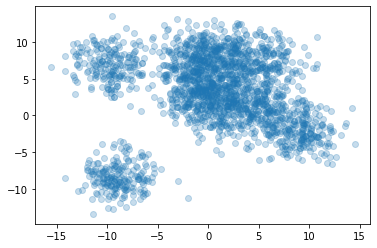

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=2000, 
                  n_features=2, 
                  centers=10, 
                  cluster_std=2,
                  shuffle=True,
                  random_state=0
                 )

plt.scatter(X[:,0], X[:,1], alpha=.25)
plt.show()

# What should be set for $k$?  
We have two primary tools to determine a reasonable number to set $k$:
- Elbow plot. 
- Silhouette plot.  

### Elbow plot
- Think of this as a type of grid search for clustering.  
- We don't have evaluation metrics, e.g., recall, that we can look to maximize, so we need to use metrics intrinsic to the clusters and data.  
- We use the within-cluster SSE (`inertia` or `distortion`) and look to see that reaches a convergence point. inertia_ is available after fitting a model.

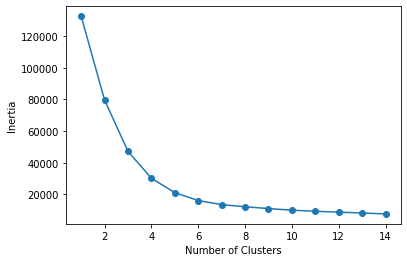

In [5]:
from sklearn.cluster import KMeans

distortions = list()

for i in range(1, 15):
    km = KMeans(n_clusters=i, random_state=0)
    km = km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 15), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

> Plot `elbows` or `kinks` at around $6$ or $7$, so we'll use that for $k$.

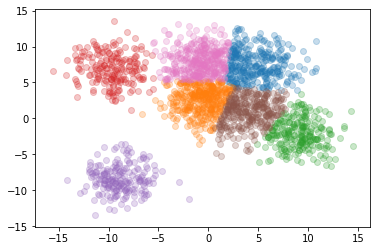

In [6]:
from sklearn.cluster import KMeans

n = 7

km = KMeans(n_clusters=n, random_state=0)
km = km.fit(X)
pclusters = km.predict(X)

for i in range(n):
    plt.scatter(X[pclusters==i, 0], X[pclusters==i, 1], alpha=0.25)
plt.show()

> Elbow method seemed to pick a reasonable number?

## Silhouette Plot
Another method for chosing $k$. It's a measure of how tightly grouped the estimates within clusters.

#### Steps
- Calculate cluster cohesion, $a^{(i)}$, which is the average distance between a sample and all other samples in the cluster. The smaller, the tighter there are together.  
- Calcuate the cluster separation, $b^{(i)}$, which is the average distance between each sample in a cluster versus the examples in the nearest cluster.  
- Calculate the silhouette, which is the distance between the cluster cohesion and the separation, divided by the greater of the two.

$$
s^{(i)} = \frac{b^{(i)}-a^{(i)}}{max(b^{(i)}, a^{(i)})}
$$

Where $s\in(-1,1)$
- A value of $1$ indicates an ideal cluster, since the clusters are dissimilar from each other.  
- A value of $0$ indicates the within and between separation is the same, so the clusters are similar to each other (we don't want this).

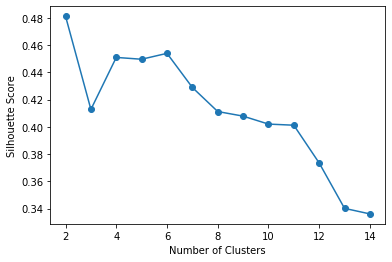

In [7]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouettes = list()

for i in range(2, 15):
    km = KMeans(n_clusters=i, random_state=0)
    km = km.fit(X)
    s = silhouette_score(X, km.labels_)
    silhouettes.append(s)
    
plt.plot(range(2,15), silhouettes, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

> Probably would ignore $2$ since it probably is separating the top and bottom blob. It materially begins to decline after $6$, so we'd likely use that for $k$.

In [8]:
from sklearn.metrics import silhouette_samples

from sklearn.cluster import KMeans

n = 7

km = KMeans(n_clusters=n, random_state=0)
km = km.fit(X)
pclusters = km.predict(X)

silhouette_vals = silhouette_samples(X, km.labels_)

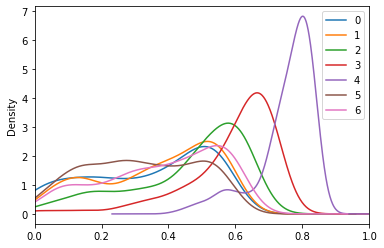

In [9]:
import pandas as pd

s_vals = pd.DataFrame(list(zip(silhouette_vals, km.labels_)))
s_vals.columns = ['silhouette', 'cluster']
s_vals = s_vals.sort_values(by=['cluster', 'silhouette'],
                          ascending=[True, False]
                          )
s_vals['idx'] = pd.Series(range(0,2000))
s_vals['cluster'] = s_vals['cluster'].astype(str)

s_vals.groupby('cluster')['silhouette'].plot.density()
plt.legend()
plt.xlim((0,1))
plt.show()

> Plot the individual values by cluster to identify potential outliers.

- Data points near $0$ are less like the examples in the cluster.  
- Heavy density near $1$ indicates the cluster is grouping similar examples and is dissimilar from other clusters.

You may also see silhouette plots like this:

<img src='files/diagrams/silhouette.png' style='width: 500px'>

[Image source: Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, Chapter 9](https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb)

### You can also use clustering for preprocessing
Since this can be used to generate a single data point per example from many, this could be used for dimension reduction in addition to segmentation.

Why it may help?
- Noise reduction.  
- Dimensionality reduction. 

In [10]:
from sklearn.datasets import load_digits

digits = load_digits()
dX, dy = digits['data'], digits['target']

from sklearn.model_selection import train_test_split
dX_train, dX_test, dy_train, dy_test = train_test_split(dX, 
                                                        dy,
                                                        test_size=0.2,
                                                        random_state=100
                                                       )

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='liblinear')
log_reg = log_reg.fit(dX_train, dy_train)

log_reg_score = log_reg.score(dX_test, dy_test)
print(f'Score: {log_reg_score:.2%}')

Score: 95.83%


#### Now we'll see using the clusters from k-Means

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

p = Pipeline([('sc', StandardScaler()),
             ('kmeans', KMeans(n_clusters=100)),
              ('logreg', LogisticRegression(solver='liblinear'))])

p = p.fit(dX_train, dy_train)
p_score = p.score(dX_test, dy_test)
print(f'Using k-means preprocesser: {p_score:.2%}')

Using k-means preprocesser: 97.22%


- You could use GridSearchCV to find the best number of clusters.  
- We picked $100$ based on literature on this dataset, but you would want to search for the best values.

# Another Application: Semi-Supervised Learning
Let's pretend we only had 50 labeled images for the digits dataset.  
- Something like this is somewhat common, especially with text or images.

In [12]:
n_labeled = 50

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(dX_train[:n_labeled], dy_train[:n_labeled])

small_n_score = log_reg.score(dX_test, dy_test)
print(f'Accuracy with only 50 training examples: {small_n_score:.2%}')

Accuracy with only 50 training examples: 80.00%


> Accuracy much lower than with the full training dataset.

#### What if we create labels from the clusters?
We label other instances that are really close to centroids after running k-Means?

First, we'll need to determine clusters, then determine which labeled instance is closest to the centroid.

[Taken from *Hands on Machine Learning with Scikit-Learn, Keras & TensorFlow pages 253-254*](https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb)

In [13]:
import numpy as np

k = 100

kmeans = KMeans(n_clusters = k)
X_digits_dist = kmeans.fit_transform(dX_train)

representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = dX_train[representative_digit_idx]

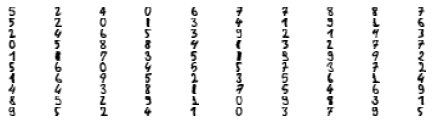

In [14]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

> If we didn't have the labels, we would need to manually look at these and label these manually. Since we have the labels, we'll skip that manual exercise, but be aware it would be necessary.

In [15]:
y_representative_digits = dy_train[representative_digit_idx]

log_reg = LogisticRegression(solver='liblinear')
log_reg = log_reg.fit(X_representative_digits, y_representative_digits)

new_scr = log_reg.score(dX_test, dy_test)
print(f'Accuracy with only 50 representative training examples: {new_scr:.2%}')

Accuracy with only 50 representative training examples: 92.50%


#### Significant improvement in accuracy! Can we do better?
Now we'll iteratively create labels all the instances in the cluster and the closest digit.

In [16]:
y_train_propagated = np.empty(len(dX_train), dtype=np.int32)

for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]
    
log_reg = LogisticRegression(solver='liblinear')
log_reg = log_reg.fit(dX_train, y_train_propagated)

new_scr = log_reg.score(dX_test, dy_test)
print(f'Accuracy with propagation: {new_scr:.2%}')

Accuracy with propagation: 94.44%


> Another performance boost!

#### What if we only took the closest examples?
We'll try only propagating to the examples in the closest 20th percentile.

In [17]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(dX_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1
    
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = dX_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

new_scr = log_reg.score(dX_test, dy_test)
print(f'Accuracy with propagation: {new_scr:.2%}')

Accuracy with propagation: 93.33%


# Agglomerative (hierarchical) clustering
Another clustering method builds the clusters as parts of a tree and let's us visualize it via a `dendrogram`.

This can be a useful technique if you expect some type of structure, e.g., you are trying to cluster on recipes. You would expect (hope) the french recipes get grouped together, the Chinese recipes grouped together, ... and then the various variations within those grouped in the terminal nodes.

### Basic Steps
- Compute a distance matrix for the examples (this could be very large).  
- Each example starts as its own cluster.  
- Merge the two closest clusters based on distance.  
- Update the similarity (linkage) matrix.  
- Repeat until one cluster remains.  

This is a bottom-up mode, since we start with the individual examples and slowly group them into more and more heterogenous clusters until we are back to the entire dataset.

- You can use Euclidean distance or a custom method of your choosing. 
- Since this is based on distance; you'll want to standardize your features first!  
- Linkage is how the clusters are compared for similarity to one another:

<img src='files/diagrams/linkage.png' style='width: 500px'>

[Image source Machine Learning with Python 3rd Edition Page 368](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch11)

### Hierarchial Clustering with the Wine Data

In [18]:
import pandas as pd

wine = pd.read_csv('data/wine.data', header=None)

wineColumns = ['Type',
'Alcohol',
'Malic acid',
'Ash',
'Alcalinity of ash',
'Magnesium',
'Total phenols',
'Flavanoids',
'Nonflavanoid phenols',
'Proanthocyanins',
'Color intensity',
'Hue',
'OD280/OD315 of diluted wines',
'Proline'
]

wine.columns = wineColumns

wine.head()

,Type,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [19]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Type                          178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

#### Scale the data and run the algorithm

In [20]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# pretending we don't know the type
wine_X = wine.iloc[:, 1:]

wine_X = StandardScaler().fit_transform(wine_X)

ac = AgglomerativeClustering(n_clusters=5, 
                             affinity='euclidean', 
                             linkage='complete',
                             compute_distances=True
                            )

labels = ac.fit_predict(wine_X)

print('Clustering completed.')

Clustering completed.


#### Now we can plot the dendrogram
[`plot_dengrogram` taken from scikit-learn example.](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py)

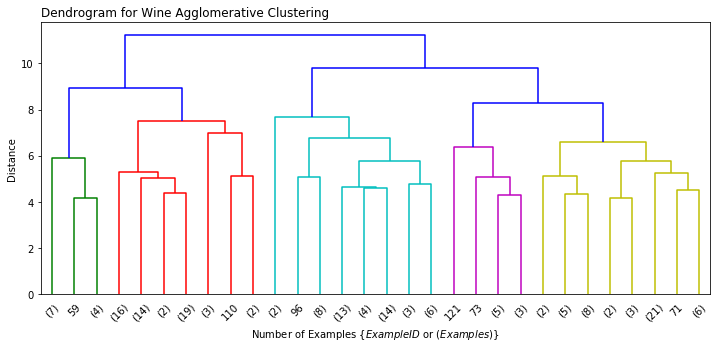

In [21]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.figure(figsize=(12,5))
plot_dendrogram(ac, truncate_mode='lastp')
plt.xlabel('Number of Examples {$Example ID$ or $(Examples)$}')
plt.ylabel('Distance')
plt.title('Dendrogram for Wine Agglomerative Clustering', loc='left')
plt.show()

- Can be useful in identifying outliers or seeing how close examples are to one another.  
- Still need to review features to determine what the clusters represent.  

# Density-based Spatial Clustering of Applications with Noise (DBSCAN)
- Density-based clustering - essentially identifying areas of continuous high density. 
- No assumptions about whether the clusters are spherical or not.  
- No assumptions about hierarchies.  
- Can identity points that are outliers.  

### Each Example is Assigned a Label 
- Core point: if it's sufficiently close to neighbors defined by a minimum number (`MinPts`) falling within a radius, $\epsilon$. Points within $\epsilon$ are also considered its neighborhood.  
- Border point: on the outside border of the cluster boundary, defined by being within the radius ($\epsilon$) of a core point but lacking the minimum number of neighbors.  
- Noise point: think of these as outliers that aren't attached to any clusters.  

### Basic Process
- Create clusters for each core point or connected group. They are considered connected if they are within $\epsilon$.  
- Assign the border points.

<img src='files/diagrams/dbscan.png' style='width: 600px'>

[Image source Machine Learning with Python 3rd Edition Page 377](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch11)

### Biggest Advantages
- Identifies noise/outliers. 
- No assumptions on structure.  

## Example with Half-Moons

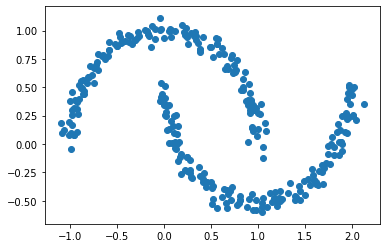

In [22]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.05, random_state=0)

plt.scatter(X[:,0], X[:,1])
plt.show()

### See how k-Means handles this data

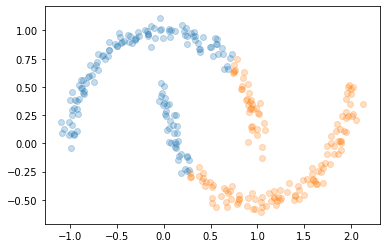

In [23]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)
km = km.fit(X)

pclusters = km.predict(X)

for i in range(n):
    plt.scatter(X[pclusters==i, 0], X[pclusters==i, 1], alpha=0.25)
plt.show()

> k-Means assumes spherical clusters, so this isn't going to work...  

### Now with DBSCAN
> Note: there isn't a `.predict()` method for DBSCAN since it's meant to identify clusters based on the current dataset. If you needed predictions, you could use the outputs and use with KMeans. See pages 257-258 of *Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow*.

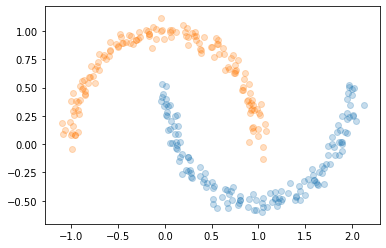

In [24]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
pclusters = db.fit_predict(X)
labs = db.labels_
ulabs = np.unique(labs)

for i in ulabs:
    plt.scatter(X[pclusters==i, 0], X[pclusters==i, 1], alpha=0.25)
plt.show()

- DBSCAN was able to identity the areas of continously density, and thus, the half moons.  
- So for data of arbitrary shapes, this will probably perform better than k-Means or hierarchical clustering.  

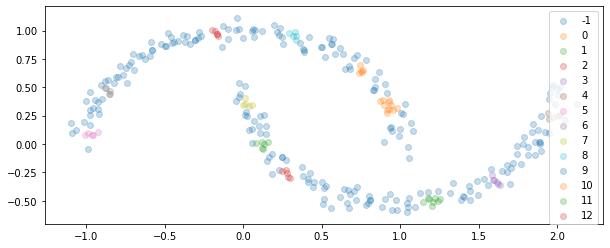

In [25]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.05, min_samples=5, metric='euclidean')
pclusters = db.fit_predict(X)
labs = db.labels_
ulabs = np.unique(labs)

plt.figure(figsize=(10,4))
for i in ulabs:
    plt.scatter(X[pclusters==i, 0], X[pclusters==i, 1], alpha=0.25)
plt.legend(ulabs)
plt.show()

> Setting the radius too small, and nearly everything could be an outlier ($-1$).

### Cons
- Vulnerable to curse of dimensionality (not unique, not something to be aware of).  
- Need to determine $\epsilon$ and the minimum number of points.  
- If the density if very uneven, finding reasonable choices for $\epsilon$ and the minimum points could be challenging.  

# Additional Clustering Algorithms
- [BIRCH](https://en.wikipedia.org/wiki/BIRCH)  
- [Mean-Shift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)  
- [Affinity](https://en.wikipedia.org/wiki/Affinity_propagation)  
- [Spectral clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)  